# Fall Detection Tutorial

This notebook provides a tutorial for running inference on a static image in order to predict if any person detected within the image has fallen down. A box is drawn around any fallen person.

First, we need to import the appropriate OpenDR classes. We need the fall detector learner and a pose estimator learner. Fall detection works with a provided pose estimator to calculate poses. We will use the Lightweight OpenPose pose estimator provided by the OpenDR Toolkit.

In [1]:
from opendr.perception.pose_estimation import LightweightOpenPoseLearner
from opendr.perception.fall_detection import FallDetectorLearner

We create the pose estimator using two refinement stages and disabling stride to achieve best accuracy.

In [2]:
 pose_estimator = LightweightOpenPoseLearner(device='cuda', num_refinement_stages=2, mobilenet_use_stride=False)

Note that we can alter the device (e.g., 'cpu', 'cuda', etc.), on which the model runs.

After creating our model, we need to download and load the pre-trained weights:

In [3]:
pose_estimator.download(path=".", verbose=True)
pose_estimator.load("openpose_default")

Metadata json file already exists.
Trained model .pth file already exists.
Pretrained model download complete.


Next, we initialize the fall detector using the pose estimator defined:

In [4]:
fall_detector = FallDetectorLearner(pose_estimator)

Now we need to download some test images using the download utility provided by the fall detector

In [5]:
fall_detector.download(".", verbose=True)

Test data download complete.


Let's load and view a couple of images:

In [6]:
import cv2
from opendr.engine.data import Image

img_standing = Image.open("./test_images/standing.png")

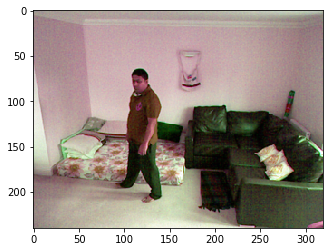

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(img_standing.opencv()[:, :, [2, 0, 1]])

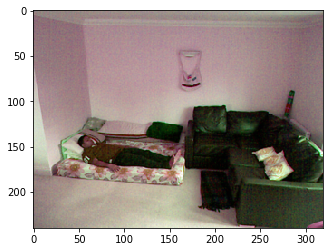

In [8]:
img_fallen = Image.open("./test_images/fallen.png")
plt.imshow(img_fallen.opencv()[:, :, [2, 0, 1]])

Note that the images are taken from the [UR Fall Detection Dataset](http://fenix.univ.rzeszow.pl/~mkepski/ds/uf.html).

Now we can use the model to get fall detection on these images, by running the inference method provided. Note that there are standard data types supported by OpenDR. However, OpenDR also understands common data types (e.g,. OpenCV images) and automatically converts them into the most appropriate format:

In [9]:
detections_standing = fall_detector.infer(img_standing)
detections_fallen = fall_detector.infer(img_fallen)
print(detections_standing)

[(<opendr.engine.target.Category object at 0x7f88c8e2c8e0>, [<opendr.engine.target.Keypoint object at 0x7f88c8db5c40>, <opendr.engine.target.Keypoint object at 0x7f88c8db5ca0>, <opendr.engine.target.Keypoint object at 0x7f88c8db5d00>], <opendr.perception.pose_estimation.lightweight_open_pose.filtered_pose.FilteredPose object at 0x7f88d22a70a0>)]


The fall detector returns a list of detections, one for each person detected. For each person we have a `Category` object which contains the fall prediction, a list of three keypoints defining two lines along the pose that are used by the fall detector to figure out whether the pose is that of a fallen person, and lastly, the full pose detected that we can use for other purposes.

Since we have only one person on the images, we will grab the fall prediction from the first element (fall prediction) of each detection list:

In [10]:
prediction_standing = detections_standing[0][0].data
prediction_fallen = detections_fallen[0][0].data

By printing we can see that the prediction for the first image is `-1` which means that a standing person was detected, whereas for the second image it is `1`, which means a fallen person was detected.

In [11]:
print(prediction_standing, prediction_fallen)

-1 1


We can use the pose detected to draw a bounding box to signify that we detected a fallen person:

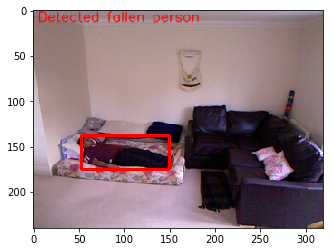

In [12]:
from opendr.perception.pose_estimation import draw, get_bbox

img_fallen = img_fallen.opencv()
x, y, w, h = get_bbox(detections_fallen[0][2])
cv2.rectangle(img_fallen, (x, y), (x + w, y + h), (0, 0, 255), 2)
cv2.putText(img_fallen, "Detected fallen person", (5, 12), cv2.FONT_HERSHEY_SIMPLEX,
            0.5, (0, 0, 255), 1, cv2.LINE_AA)

plt.imshow(img_fallen[:,:, [2, 1, 0]])

Lastly, we can draw the fall detection lines that the detector uses to determine whether the person has fallen:

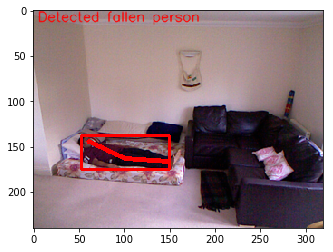

In [13]:
keypoints = detections_fallen[0][1]
cv2.line(img_fallen, (int(keypoints[0].x), int(keypoints[0].y)),
         (int(keypoints[1].x), int(keypoints[1].y)), (0, 0, 255), 4)
cv2.line(img_fallen, (int(keypoints[1].x), int(keypoints[1].y)),
         (int(keypoints[2].x), int(keypoints[2].y)), (0, 0, 255), 4)
plt.imshow(img_fallen[:,:, [2, 1, 0]])

This particular pose is classified as fallen using the line that runs between the person's hips and the person's ankles. The detector calculates the angle of the line off vertical and determines that the person is fallen, due to the fact that their legs are horizontal.

Lastly, note that this rule-based implementation of fall detection is really fast, and the pose is also returned which can be used for other purposes.